# Step 2: Add SageMaker processing and training jobs
In this step you move data processing and model training into [SageMaker Docker containers](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html) and use [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/index.html) to interact with SageMaker.

![](img/six-steps-2.png)

SageMaker makes use of Docker containers to enable developers to process data, train and deploy models. Containers allow developers and data scientists to package software into standardized units that run consistently on any platform that supports Docker. Containers ensure that code, runtime, system tools, system libraries, and settings are all in the same place, isolating them from the execution environment. It guarantees a consistent runtime experience regardless of where a container is being run.

SageMaker also provides pre-build containers with popular data processing frameworks and ML algorithms. All SageMaker built-in algorithms are delivered as Docker containers.

<div class="alert alert-info"> Make sure you using <code>Python 3</code> kernel in JupyterLab for this notebook.</div>

In [1]:
%pip install seaborn

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.10/site-packages/pytz-2023.3.dist-info/METADATA'


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
import time
import boto3
import botocore
import numpy as np  
import pandas as pd  
import sagemaker
import os
import mlflow
from time import gmtime, strftime, sleep
from sagemaker.processing import FrameworkProcessor, ProcessingInput, ProcessingOutput
from sagemaker.sklearn.estimator import SKLearn
from sklearn.metrics import roc_auc_score


sagemaker.__version__

'2.224.4'

In [3]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Stored variables and their in-db values:
baseline_s3_url                         -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
bucket_name                             -> 'sagemaker-us-east-1-906545278380'
bucket_prefix                           -> 'from-idea-to-prod/xgboost'
dataset_feature_group_name              -> 'from-idea-to-prod-08-09-07-15'
dataset_file_local_path                 -> 'data/bank-additional/bank-additional-full.csv'
domain_id                               -> 'd-1dklekwofndh'
evaluation_s3_url                       -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
experiment_name                         -> 'from-idea-to-prod-experiment-15-15-11-00'
feature_store_bucket_prefix             -> 'from-idea-to-prod/feature-store'
initialized                             -> True
input_s3_url                            -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
mlflow_arn                              -> 'arn:aws:sagemaker:us-east-1:906545278380:mlflow

In [4]:
session = sagemaker.Session()
sm = session.sagemaker_client

## Load or create a new experiment
Load the existing experiment we created in the previous notebook. You're going to track new runs in the same experiment.
You can also create a new experiment to track runs in this notebook – in this case just uncomment the following code cell.

In [5]:
experiment_suffix = strftime('%d-%H-%M-%S', gmtime())
registered_model_name = f"from-idea-to-prod-job-model-{experiment_suffix}"

In [6]:
# Uncomment code block (Cmd + /) if you would like to create a new experiment

# experiment_name = f"from-idea-to-prod-experiment-{experiment_suffix}"

In [7]:
mlflow.set_tracking_uri(mlflow_arn)
experiment = mlflow.set_experiment(experiment_name=experiment_name)

2024/07/21 10:48:23 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-experiment-15-15-11-00' does not exist. Creating a new experiment.


## Process data in SageMaker processing job
Use [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) by simply providing a Python data preprocessing script and choosing a [SageMaker SDK processor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html) class.
You must upload the input data to S3 and specify an S3 location for output data. SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete. The processing container image can either be an Amazon SageMaker built-in image or a custom image that you provide. The underlying infrastructure for a Processing job is fully managed by Amazon SageMaker. Cluster resources are provisioned for the duration of your job, and cleaned up when a job completes.

![](img/sagemaker-processing.png)

Your input data must be stored in an Amazon S3 bucket. Alternatively, you can use [Amazon Athena](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.dataset_definition.inputs.AthenaDatasetDefinition) or [Amazon Redshift](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.dataset_definition.inputs.AthenaDatasetDefinition) as input sources.

Upload the input dataset to an Amazon S3 bucket:

In [8]:
input_s3_url = session.upload_data(
    path="data/bank-additional/bank-additional-full.csv",
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix}/input"
)

%store input_s3_url

Stored 'input_s3_url' (str)


In [9]:
# !aws s3 ls {bucket_name}/{bucket_prefix} --recursive

<div class="alert alert-info"> Since you're using MLflow in the processing script, you need to provide a <code>requirements.txt</code> so that the container installs mlflow and MLflow SageMaker plugin before running the processing script.</div>

In [9]:
dependencies_dir="./processing/requirements/"
%mkdir -p processing
%mkdir -p {dependencies_dir}

In [10]:
%%writefile {dependencies_dir}requirements.txt
mlflow==2.13.2
sagemaker-mlflow==0.1.0

Overwriting ./processing/requirements/requirements.txt


Create a Python script by moving the data processing code from the step 1 notebook to a .py file and adding experiment tracking with MLflow:

In [11]:
%%writefile processing/preprocessing.py

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd
import numpy as np
import argparse
import os

from time import gmtime, strftime, sleep
import traceback

import mlflow

user_profile_name = os.getenv('USER')

def _parse_args():
    
    parser = argparse.ArgumentParser()
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    
    return parser.parse_known_args()

def process_data(df_data):
    # Indicator variable to capture when pdays takes a value of 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicator for individuals not actively employed
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remove unnecessary data
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    bins = [18, 30, 40, 50, 60, 70, 90]
    labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']

    df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
    df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
    df_model_data.drop('age', axis=1, inplace=True)
    df_model_data.drop('age_range', axis=1, inplace=True)

    scaled_features = ['pdays', 'previous', 'campaign']
    df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])

    df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Convert categorical variables to sets of indicators

    # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )
    
    return df_model_data

if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    
    target_col = "y"

    # Set the Tracking Server URI using the ARN of the Tracking Server you created
    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_ARN'])
    
    # Enable autologging in MLflow
    mlflow.autolog()

    # Use the active run_id to log 
    with mlflow.start_run(run_id=os.environ['MLFLOW_RUN_ID']) as run:
        # process data
        df_model_data = process_data(pd.read_csv(os.path.join(args.filepath, args.filename), sep=";"))
    
        # Shuffle and splitting dataset
        train_data, validation_data, test_data = np.split(
            df_model_data.sample(frac=1, random_state=1729),
            [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
        )
    
        print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
        mlflow.log_params(
            {
                "train": train_data.shape,
                "validate": validation_data.shape,
                "test": test_data.shape
            }
        )

        mlflow.set_tags(
            {
                'mlflow.user':user_profile_name,
                'mlflow.source.type':'JOB'
            }
        )
        
        # Save datasets locally
        train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
        validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
        test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
        test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
        
        # Save the baseline dataset for model monitoring
        df_model_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)

        mlflow.log_artifact(local_path=os.path.join(args.outputpath, 'baseline/baseline.csv'))
    
    print("## Processing complete. Exiting.")

Overwriting processing/preprocessing.py


The processing script contains a statement to save the whole dataset without the header and the label column as a baseline dataset. You need the data baseline later on in the model monitoring notebook.

Set the Amazon S3 paths:

In [12]:
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"
baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"

In [13]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)


Set the framework version and type and number of compute instances:

In [14]:
skprocessor_framework_version = "1.2-1"
processing_instance_type = "ml.m5.large"
processing_instance_count = 1

### Create a experiment run
Create a new run in your experiment to track parameters, configuration, inputs, and outputs of the processing job.

In [15]:
run_suffix = strftime('%d-%H-%M-%S', gmtime())
run_name = f"container-processing-{run_suffix}"

run_id = mlflow.start_run(
    run_name=run_name,
    description="feature-engineering in the notebook 02 with a processing job").info.run_id

### Create a processor and set inputs and outputs
Instantiate a [`FrameworkProcessor`](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) object before starting the SageMaker processing job. You specify the instance type to use in the job, as well as how many instances for distributed processing.

Note how SageMaker maps your data to the local paths on the processing container's EBS volume:

![](img/data-processing.png)

In [20]:
sklearn_processor = FrameworkProcessor(
    estimator_cls=SKLearn,
    framework_version=skprocessor_framework_version,
    role=sm_role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name='from-idea-to-prod-processing',
    sagemaker_session=session,
    env={
        'MLFLOW_TRACKING_ARN': mlflow_arn,
        'MLFLOW_RUN_ID': run_id,
        'USER': user_profile_name
    }
)

processing_inputs = [
        ProcessingInput(
            source=input_s3_url, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        ),
        ProcessingInput(
            input_name="processor",
            source=dependencies_dir,
            destination="/opt/ml/processing/input/code/requirements/",
        ),
    ]

processing_outputs = [
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_s3_url,
        ),
        ProcessingOutput(
            output_name="validation_data", 
            source="/opt/ml/processing/output/validation", 
            destination=validation_s3_url
        ),
        ProcessingOutput(
            output_name="test_data", 
            source="/opt/ml/processing/output/test", 
            destination=test_s3_url
        ),
        ProcessingOutput(
            output_name="baseline_data", 
            source="/opt/ml/processing/output/baseline", 
            destination=baseline_s3_url
        ),
    ]

#### Start the SageMaker processing job



In [21]:
sklearn_processor.run(
    inputs=processing_inputs,
    outputs=processing_outputs,
    code='processing/preprocessing.py',
    dependencies=[f'{dependencies_dir}requirements.txt'],
    wait=True,
    # arguments = ['arg1', 'arg2'],
)

mlflow.set_tags(
    {
        'mlflow.source.name':f'https://{region}.console.aws.amazon.com/sagemaker/home?region={region}#/processing-jobs/{sklearn_processor.latest_job.name}',
    }
)

mlflow.end_run()

INFO:sagemaker:Creating processing-job with name from-idea-to-prod-processing-2024-07-21-11-01-44-527


...............Found existing installation: typing 3.7.4.3
Uninstalling typing-3.7.4.3:
  Successfully uninstalled typing-3.7.4.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 2.0 MB/s 

In [22]:
# If you set wait to False in the previous code cell, wait until the job completes
while sm.describe_processing_job(
        ProcessingJobName=sklearn_processor._current_job_name
    )["ProcessingJobStatus"] != "Completed":
    time.sleep(10)
    print(f"Wait until {sklearn_processor._current_job_name} completed")
else:
    print(f"{sklearn_processor._current_job_name} completed")

from-idea-to-prod-processing-2024-07-21-11-01-44-527 completed


To wait for job completion you can also use `boto3` [waiters](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#waiters). For example:

```python
waiter = session.sagemaker_client.get_waiter('processing_job_completed_or_stopped')
waiter.wait(ProcessingJobName=sklearn_processor._current_job_name)
```

In [23]:
# list the uploaded files
# !aws s3 ls {bucket_name}/{bucket_prefix} --recursive

## Run your local code remotely as a SageMaker job
You an use [SageMaker Python SDK decorator `@remote`](https://sagemaker.readthedocs.io/en/stable/remote_function/sagemaker.remote_function.html) to run you local code in the notebook as a SageMaker processing job – called the "Remote Function". This is an even easier way to run your Python code at scale using SageMaker distributed processing and training.

Refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator.html) in the Amazon SageMaker developer guide.

In the following section you run the data processing code as a SageMaker job using `@remote` decorator.

### Step 1: Develop and test you code locally
First, you implement and test your code locally in the notebook to verify the correctness of code and environment.

In [24]:
# Load the dataset in to DataFrame
file_name = "bank-additional-full.csv"
input_path = "./data/bank-additional" 
df_data = pd.read_csv(os.path.join(input_path, file_name), sep=";")

In [25]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# define a local function
def preprocess(
    df_data,
    tracking_server_arn=mlflow_arn,
    experiment_name=None,
    run_id=None,
):
    import mlflow
    from time import gmtime, strftime

    try:
        # Set the Tracking Server URI using the ARN of the Tracking Server you created
        mlflow.set_tracking_uri(tracking_server_arn)
        
        # Enable autologging in MLflow
        mlflow.autolog()
    
        suffix = strftime('%d-%H-%M-%S', gmtime())
        mlflow.set_experiment(experiment_name=experiment_name if experiment_name else f"preprocess-{suffix}")
        run = mlflow.start_run(run_id=run_id) if run_id else mlflow.start_run(run_name=f"local-processing-{suffix}", nested=True)
    
        target_col = "y"
        
        # Indicator variable to capture when pdays takes a value of 999
        df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)
    
        # Indicator for individuals not actively employed
        df_data["not_working"] = np.where(
            np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
        )
    
        # remove unnecessary data
        df_model_data = df_data.drop(
            ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
            axis=1,
        )
    
        bins = [18, 30, 40, 50, 60, 70, 90]
        labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']
    
        df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
        df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
        df_model_data.drop('age', axis=1, inplace=True)
        df_model_data.drop('age_range', axis=1, inplace=True)
    
        scaled_features = ['pdays', 'previous', 'campaign']
        df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])
    
        df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Convert categorical variables to sets of indicators
    
        # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
        df_model_data = pd.concat(
            [
                df_model_data["y_yes"].rename(target_col),
                df_model_data.drop(["y_no", "y_yes"], axis=1),
            ],
            axis=1,
        )
    
        # Shuffle and splitting dataset
        train_data, validation_data, test_data = np.split(
            df_model_data.sample(frac=1, random_state=1729),
            [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
        )
    
        print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")

        mlflow.log_params(
            {
                "train": train_data.shape,
                "validate": validation_data.shape,
                "test": test_data.shape
            }
        )
        
        baseline_data = df_model_data.drop([target_col], axis=1)
        
        print("## Processing complete. Exiting.")
        
        return train_data, validation_data, test_data, baseline_data

    except Exception as e:
        print(f"Exception in processing script: {e}")
        raise e
    finally:
        mlflow.end_run()

In [26]:
# Call the function locally
train_data, validation_data, test_data, baseline_data = preprocess(df_data, experiment_name=experiment_name)

2024/07/21 11:08:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/07/21 11:08:19 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/07/21 11:08:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Data split > train:(28831, 65) | validation:(8238, 65) | test:(4119, 65)
## Processing complete. Exiting.


In [27]:
# see the processed data
train_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,0,0.036364,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
9332,0,0.018182,1.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
32286,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3925,0,0.036364,1.0,0.0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
9406,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


### Step 2: Execute the function remotely using RemoteExecutor
You can use [`RemoteExecutor`](https://sagemaker.readthedocs.io/en/stable/remote_function/sagemaker.remote_function.html#remoteexecutor) SageMaker Python SDK class to run the local function remotely as a SageMaker job. You can run multiple jobs in paralle using `max_parallel_jobs` parameter to control the max number of parallel jobs.

In [28]:
from sagemaker.remote_function import remote, RemoteExecutor

In [29]:
s3_root_uri = f"s3://{bucket_name}/{bucket_prefix}"

In [30]:
# this code will start a SageMaker job to execute prerpocess script
with RemoteExecutor(dependencies=f"{dependencies_dir}requirements.txt",
                    s3_root_uri=s3_root_uri, instance_type=processing_instance_type) as e:
    future = e.submit(preprocess, df_data)                 

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-07-21 11:08:33,097 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/preprocess-2024-07-21-11-08-33-097/function
2024-07-21 11:08:33,153 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/preprocess-2024-07-21-11-08-33-097/arguments
2024-07-21 11:08:33,481 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmpq6of75_x/temp_workspace/sagemaker_remote_function_workspace'
2024-07-21 11:08:33,483 sagemaker.remote_function INFO     Copied dependencies file at './processing/requirements/requirements.txt' to '/tmp/tmpq6of75_x/temp_workspace/sagemaker_remote_function_workspace/requirements.txt'
2024-07-21 11:08:34,937 sagemaker.remote_function INFO     Successfully created workdir archive at '/tmp/tmpq6of75_x/workspace.zip'
2024-07-21 11:08:35,384 sagemaker.remote_function INFO     Successfully uploaded workdir to 's

In [32]:
train_data, validation_data, test_data, baseline_data = future.result()

2024-07-21 11:12:03 Starting - Preparing the instances for training
2024-07-21 11:12:03 Downloading - Downloading the training image
2024-07-21 11:12:03 Training - Training image download completed. Training in progress.
2024-07-21 11:12:03 Uploading - Uploading generated training model
2024-07-21 11:12:03 Completed - Training job completedINFO: CONDA_PKGS_DIRS is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/conda/pkgs'
INFO: PIP_CACHE_DIR is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/pip'
INFO: Bootstraping runtime environment.
2024-07-21 11:11:34,016 sagemaker.remote_function INFO     The job is running on non-root user: sagemaker-user. Adding write permissions to the following job output directories: ['/opt/ml/output', '/opt/ml/model', '/tmp'].
2024-07-21 11:11:34,016 sagemaker.remote_function INFO     Executing 'sudo chmod -R 777 /opt/ml/output /opt/ml/model /tmp'.
2024-07-21 11:11:34,303 sagemaker.remote_f

In [33]:
# see the processed data
train_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,0,0.036364,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
9332,0,0.018182,1.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
32286,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3925,0,0.036364,1.0,0.0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
9406,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


### Step 3: Run code with @remote decorator
Now you can apply `@remote` to the function once the local and remote test runs successfully. 
You can also set default settings for remote functions via a [configuration file](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator-config.html). The configuration file is used when invoking a function with `@remote` decorator or `RemoteExecutor` API.

In [34]:
@remote(dependencies=f"{dependencies_dir}requirements.txt",
        s3_root_uri=s3_root_uri, instance_type=processing_instance_type)
def preprocess(
    df_data,
    tracking_server_arn=mlflow_arn,
    experiment_name=None,
    run_id=None,
):
    import mlflow
    from time import gmtime, strftime

    try:
        # Set the Tracking Server URI using the ARN of the Tracking Server you created
        mlflow.set_tracking_uri(tracking_server_arn)
        
        # Enable autologging in MLflow
        mlflow.autolog()
    
        suffix = strftime('%d-%H-%M-%S', gmtime())
        mlflow.set_experiment(experiment_name=experiment_name if experiment_name else f"preprocess-{suffix}")
        run = mlflow.start_run(run_id=run_id) if run_id else mlflow.start_run(run_name=f"remote-processing-{suffix}", nested=True)
    
        target_col = "y"
        
        # Indicator variable to capture when pdays takes a value of 999
        df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)
    
        # Indicator for individuals not actively employed
        df_data["not_working"] = np.where(
            np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
        )
    
        # remove unnecessary data
        df_model_data = df_data.drop(
            ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
            axis=1,
        )
    
        bins = [18, 30, 40, 50, 60, 70, 90]
        labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']
    
        df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
        df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
        df_model_data.drop('age', axis=1, inplace=True)
        df_model_data.drop('age_range', axis=1, inplace=True)
    
        scaled_features = ['pdays', 'previous', 'campaign']
        df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])
    
        df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Convert categorical variables to sets of indicators
    
        # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
        df_model_data = pd.concat(
            [
                df_model_data["y_yes"].rename(target_col),
                df_model_data.drop(["y_no", "y_yes"], axis=1),
            ],
            axis=1,
        )
    
        # Shuffle and splitting dataset
        train_data, validation_data, test_data = np.split(
            df_model_data.sample(frac=1, random_state=1729),
            [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
        )
    
        print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")

        mlflow.log_params(
            {
                "train": train_data.shape,
                "validate": validation_data.shape,
                "test": test_data.shape
            }
        )
        
        baseline_data = df_model_data.drop([target_col], axis=1)
        
        print("## Processing complete. Exiting.")
        
        return train_data, validation_data, test_data, baseline_data

    except Exception as e:
        print(f"Exception in processing script: {e}")
        raise e
    finally:
        mlflow.end_run()
    return train_data, validation_data, test_data, baseline_data

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


In [35]:
# This call creates and run a SageMaker job
# This will also create a new experiment in MLflow
train_data, validation_data, test_data, baseline_data = preprocess(df_data)

2024-07-21 11:14:47,807 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/preprocess-2024-07-21-11-14-47-807/function
2024-07-21 11:14:47,886 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/preprocess-2024-07-21-11-14-47-807/arguments
2024-07-21 11:14:48,198 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmp137x1s0v/temp_workspace/sagemaker_remote_function_workspace'
2024-07-21 11:14:48,200 sagemaker.remote_function INFO     Copied dependencies file at './processing/requirements/requirements.txt' to '/tmp/tmp137x1s0v/temp_workspace/sagemaker_remote_function_workspace/requirements.txt'
2024-07-21 11:14:49,641 sagemaker.remote_function INFO     Successfully created workdir archive at '/tmp/tmp137x1s0v/workspace.zip'
2024-07-21 11:14:50,001 sagemaker.remote_function INFO     Successfully uploaded workdir to 's

2024-07-21 11:14:50 Starting - Starting the training job...
2024-07-21 11:15:04 Starting - Preparing the instances for training...
2024-07-21 11:15:29 Downloading - Downloading input data...
2024-07-21 11:15:59 Downloading - Downloading the training image.........
2024-07-21 11:17:45 Training - Training image download completed. Training in progress..INFO: CONDA_PKGS_DIRS is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/conda/pkgs'
INFO: PIP_CACHE_DIR is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/pip'
INFO: Bootstraping runtime environment.
2024-07-21 11:17:50,270 sagemaker.remote_function INFO     The job is running on non-root user: sagemaker-user. Adding write permissions to the following job output directories: ['/opt/ml/output', '/opt/ml/model', '/tmp'].
2024-07-21 11:17:50,270 sagemaker.remote_function INFO     Executing 'sudo chmod -R 777 /opt/ml/output /opt/ml/model /tmp'.
2024-07-21 11:17:50,550 sagemak

In [36]:
# see the processed data
train_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,0,0.036364,1.0,0.0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
9332,0,0.018182,1.0,0.0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
32286,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3925,0,0.036364,1.0,0.0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
9406,0,0.018182,1.0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


For more examples of remote functions see SageMaker [example notebooks](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator-examples.html).

## Model training with SageMaker training job
Follow the same approach and now run the model training as a [SageMaker training job](https://sagemaker.readthedocs.io/en/stable/overview.html#using-estimators) with a built-in algorithm container.

In [33]:
# get training container uri
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.5-1")

print(training_image)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


Define the data input channels for the training job. Set _train_ and _validation_ channels via the SageMaker SDK [`TrainingInput`](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) class:

In [34]:
s3_input_train = sagemaker.inputs.TrainingInput(train_s3_url, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(validation_s3_url, content_type='csv')

In [35]:
train_instance_count = 1
train_instance_type = "ml.m5.xlarge"

# Define where the training job stores the model artifact
output_s3_url = f"s3://{bucket_name}/{bucket_prefix}/output"

%store output_s3_url

Stored 'output_s3_url' (str)


Instantiate an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object and set algorithm's hyperparameters. Refer to [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for more information.

In [36]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    # use_spot_instances=True,  # Use spot instances to reduce cost
    # max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-training", # Prefix for training job name
)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=50, # the number of rounds to run the training
    max_depth=3, # maximum depth of a tree
    eta=0.5, # step size shrinkage used in updates to prevent overfitting
    alpha=2.5, # L1 regularization term on weights
    objective="binary:logistic",
    eval_metric="auc", # evaluation metrics for validation data
    subsample=0.8, # subsample ratio of the training instance
    colsample_bytree=0.8, # subsample ratio of columns when constructing each tree
    min_child_weight=3, # minimum sum of instance weight (hessian) needed in a child
    early_stopping_rounds=10, # the model trains until the validation score stops improving
    verbosity=1, # verbosity of printing messages
)

In [37]:
estimator.hyperparameters()

{'num_round': 50,
 'max_depth': 3,
 'eta': 0.5,
 'alpha': 2.5,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'min_child_weight': 3,
 'early_stopping_rounds': 10,
 'verbosity': 1}

Set training inputs and outputs:

In [38]:
training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

In [39]:
# helper function to load XGBoost model into xgboost.Booster
def load_model(model_data_s3_uri):
    import xgboost as xgb
    import tarfile
    import pickle as pkl

    model_file = "./xgboost-model.tar.gz"
    bucket, key = model_data_s3_uri.replace("s3://", "").split("/", 1)
    boto3.client("s3").download_file(bucket, key, model_file)
    
    with tarfile.open(model_file, "r:gz") as t:
        t.extractall(path=".")
    
    # Load model
    model = xgb.Booster()
    model.load_model("xgboost-model")

    return model

Run the training:

In [40]:
mlflow.set_experiment(experiment_name=experiment_name)
with mlflow.start_run(
    run_name=f"container-training-{strftime('%d-%H-%M-%S', gmtime())}",
    description="training in the notebook 02 with a training job") as run:
    mlflow.log_params(estimator.hyperparameters())
        
    estimator.fit(
        training_inputs,
        wait=True,
        logs=False,
    ) 
    
    mlflow.set_tags(
        {
            'mlflow.user':user_profile_name,
            'mlflow.source.name':f'https://{region}.console.aws.amazon.com/sagemaker/home?region={region}#/jobs/{estimator.latest_training_job.name}',
            'mlflow.source.type':'JOB'
        }
    )
    mlflow.log_param("training job name", estimator.latest_training_job.name)
    mlflow.log_metrics({i['metric_name'].replace(':', '_'):i['value'] for i in estimator.training_job_analytics.dataframe().iloc})
    mlflow.xgboost.log_model(load_model(estimator.model_data), artifact_path="xgboost")

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-07-16-08-20-24-920



2024-07-16 08:20:26 Starting - Starting the training job.
2024-07-16 08:20:40 Starting - Preparing the instances for training.....
2024-07-16 08:21:07 Downloading - Downloading input data.....
2024-07-16 08:21:37 Downloading - Downloading the training image.......
2024-07-16 08:22:18 Training - Training image download completed. Training in progress...
2024-07-16 08:22:33 Uploading - Uploading generated training model.
2024-07-16 08:22:42 Completed - Training job completed


2024/07/16 08:22:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Register this model in MLflow model registry. The model is automatically replicated into SageMaker Model Registry.

In [41]:
model_uri = f"runs:/{mlflow.last_active_run().info.run_id}/xgboost"
mv = mlflow.register_model(model_uri, registered_model_name)

Successfully registered model 'from-idea-to-prod-job-model-16-07-42-00'.
2024/07/16 08:25:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: from-idea-to-prod-job-model-16-07-42-00, version 1
Created version '1' of model 'from-idea-to-prod-job-model-16-07-42-00'.


### Reduce training job startup time with warm pools
💡 Instead of using each time a new ephemeral computation cluster to train your models, you can keep your model training hardware instances warm after every job for a specified period. Refer to [Reduce ML Model Training Job startup time by up to 8x using SageMaker Training Managed Warm Pools](https://aws.amazon.com/about-aws/whats-new/2022/09/reduce-ml-model-training-job-startup-time-8x-sagemaker-training-managed-warm-pools/) for more details. If you opt to use warm pools, you are billed for the instances and EBS volumes for the duration of the keep-alive period. 
Refer to [ Train Using SageMaker Managed Warm Pools](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html) in the Amazon SageMaker Developer Guide for details on training API.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <p style=" text-align: center; margin: auto;">To use warm pool feature you must have a corresponding warm pool quota for a required instance type set to value greater than 0.
    <br>
    <br>
    Do not run this section in AWS provisioned workshop account as the warm pool quota is set to 0.
    The following section checks the quota value for the training instance type.
    </p>
</div>

In [42]:
def check_quota(quota_code, min_v):
    r = quotas_client.get_service_quota(
        ServiceCode="sagemaker",
        QuotaCode=quota_code,
    )
    
    q = r["Quota"]["Value"]
    n = r["Quota"]["QuotaName"]

    if q < min_v:
        print (
            f"WARNING: Your quota {q} for {n} is less than required value of {min_v}"
        )
    else:
        print(
            f"SUCCESS: Your quota {q} for {n} is equal or more than required value of {min_v}"
        )

In [43]:
quotas_client = boto3.client("service-quotas")
                      
quotas = {
    "ml.m5.large": ["L-2DD73636", 1],
    "ml.m5.xlarge": ["L-0BEF44E8", 1],
    "ml.m5.2xlarge": ["L-1686EE8B", 1],
}
     
check_quota(quotas[train_instance_type][0], quotas[train_instance_type][1])

#### Optional: Train with SageMaker warm pools
Let's use this feature and run XGBoost training using warm pools.
Notice the matching attributes of a training job to re-use the provisioned infrastructure from a previous job: [Matching criteria](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html#train-warm-pools-matching-criteria)

To create a warm pool you need to set `KeepAlivePeriodInSeconds` parameter in `Estimator` configuration to value greater than 0.

In [46]:
# Instantiate an XGBoost estimator object
warm_pool_estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    # use_spot_instances=True,  # Use spot instances to reduce cost
    # max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-training", # Prefix for training job name
    keep_alive_period_in_seconds=1800, # use the warm pool feature
)

In [47]:
training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

Run a training job by calling `estimator.fit()` several consequent times with different hyperparameters. The initial training job "cold-starts" as SageMaker provisions required compute infrastructure for it. When this job completes, the infrastructure kept alive for the period `KeepAlivePeriodInSeconds`. The warm pool stays `Available` until it either identifies a matching training job for reuse or it exceeds the specified `KeepAlivePeriodInSeconds` and is terminated.

In [48]:
# Start a new experiment to log execution times for each estimator fit
suffix = strftime('%d-%H-%M-%S', gmtime())
mlflow.set_experiment(experiment_name=f"from-idea-to-prod-warm-pools-{suffix}")

with mlflow.start_run(
    run_name=f"container-warm-pools-{suffix}",
    description="warm pools experiment in the notebook 02") as parent_run:
    # run the training job five times
    for i, d in enumerate([2, 3, 5, 10, 20]):
        print(f"Fit estimator with max_depth={d}")
    
        warm_pool_estimator.set_hyperparameters(
            num_round=50, # the number of rounds to run the training
            max_depth=d, # maximum depth of a tree
            objective="binary:logistic",
            eval_metric="auc", # evaluation metrics for validation data
            early_stopping_rounds=10, # the model trains until the validation score stops improving
        )

        with mlflow.start_run(
            run_name=f"max_depth={d}",
            description=f"Fit estimator with max_depth={d}",
            nested=True) as child_run:
            mlflow.log_params(warm_pool_estimator.hyperparameters())
            
            warm_pool_estimator.fit(
                training_inputs,
                wait=True,
                logs=False,
            )
            
            mlflow.log_metrics({i['metric_name'].replace(':', '_'):i['value'] for i in warm_pool_estimator.training_job_analytics.dataframe().iloc})

2024/07/07 20:33:51 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-warm-pools-07-20-33-51' does not exist. Creating a new experiment.
INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-07-07-20-33-51-926


Fit estimator with max_depth=2

2024-07-07 20:33:53 Starting - Starting the training job..
2024-07-07 20:34:07 Starting - Preparing the instances for training....
2024-07-07 20:34:34 Downloading - Downloading input data....
2024-07-07 20:35:00 Downloading - Downloading the training image........
2024-07-07 20:35:45 Training - Training image download completed. Training in progress...
2024-07-07 20:36:01 Uploading - Uploading generated training model.
2024-07-07 20:36:10 Completed - Resource retained for reuse

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-07-07-20-36-14-354


Fit estimator with max_depth=3

2024-07-07 20:36:17 Starting - Found matching resource for reuse
2024-07-07 20:36:17 Downloading - Downloading input data.
2024-07-07 20:36:28 Training - Training image download completed. Training in progress..
2024-07-07 20:36:38 Uploading - Uploading generated training model.
2024-07-07 20:36:48 Completed - Resource retained for reuse

Fit estimator with max_depth=5


INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-07-07-20-36-50-796



2024-07-07 20:36:55 Starting - Found matching resource for reuse
2024-07-07 20:36:55 Downloading - Downloading input data.
2024-07-07 20:37:05 Training - Training image download completed. Training in progress.
2024-07-07 20:37:11 Uploading - Uploading generated training model..
2024-07-07 20:37:25 Completed - Resource retained for reuse

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-07-07-20-37-27-163


Fit estimator with max_depth=10

2024-07-07 20:37:31 Starting - Found matching resource for reuse
2024-07-07 20:37:31 Downloading - Downloading input data.
2024-07-07 20:37:41 Training - Training image download completed. Training in progress.
2024-07-07 20:37:47 Uploading - Uploading generated training model..
2024-07-07 20:38:01 Completed - Resource retained for reuse

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-07-07-20-38-03-577


Fit estimator with max_depth=20

2024-07-07 20:38:08 Starting - Found matching resource for reuse
2024-07-07 20:38:08 Downloading - Downloading input data.
2024-07-07 20:38:18 Training - Training image download completed. Training in progress..
2024-07-07 20:38:29 Uploading - Uploading generated training model.
2024-07-07 20:38:38 Completed - Resource retained for reuse

You can validate that a warm pool used for this training job by going to the [SageMaker training job console](https://console.aws.amazon.com/sagemaker/home?#/jobs) and inspect the training job list:

![](img/warm-pools-training-jobs.png)

The first training job should take about several minutes, but all subsequent jobs reuse the same compute instance and completed in several seconds. You can also see the warm pool status and time left.

You can also open an MLflow experiment list and select an `from-idea-to-prod-warm-pools-<timestamp>` experiment. The logged run duration shows that the first training took about 2 min and all consequent runs less than 40 sec:

![](img/warm-pools-mlflow.png)

### Output model performance

In [44]:
if estimator._current_job_name:
    training_job_name = estimator._current_job_name

In [45]:
metrics = None
while not metrics:
    metrics = sm.describe_training_job(
        TrainingJobName=training_job_name
        ).get("FinalMetricDataList")

    if not metrics:
        print(f"Training job {training_job_name} hasn't finished yet!")
        time.sleep(10)
    
train_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'train:auc'][0])
validate_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'validation:auc'][0])

print(f"Train-auc:{train_auc:.2f}, Validate-auc:{validate_auc:.2f}")

Train-auc:0.79, Validate-auc:0.77


You can also see the model metrics from the MLflow registered model. You registered the model after the latest training job run:

In [46]:
mlflow.get_run(mv.run_id).data.metrics

{'validation_auc': 0.770995, 'train_auc': 0.78251}

In [47]:
%store training_job_name

Stored 'training_job_name' (str)


In [48]:
# Print the S3 path to the model artifact:
estimator.model_data

's3://sagemaker-us-east-1-402709838713/from-idea-to-prod/xgboost/output/from-idea-to-prod-training-2024-07-16-08-20-24-920/output/model.tar.gz'

## Validate model
The training job saved a model in the specified location on Amazon S3.

You can deploy the model as a [real-time endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html), which is just one [function call](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.deploy), or create a [batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to predict a label for a large dataset.

### Real-time inference
To test [real-time inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) you create a real-time endpoint using the trained estimator.

In [49]:
# Real-time endpoint
endpoint_name = f"from-idea-to-prod-endpoint-{strftime('%d-%H-%M-%S', gmtime())}"

try:
    predictor = estimator.deploy(
        initial_instance_count=1,
        instance_type="ml.m5.large",
        wait=False,  # Remember, predictor.predict() won't work until deployment finishes!
        # Turn on data capture here, in case you want to experiment with monitoring:
        data_capture_config=sagemaker.model_monitor.DataCaptureConfig(
            enable_capture=True,
            sampling_percentage=100,
            destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
        ),
        endpoint_name=endpoint_name,
        serializer=sagemaker.serializers.CSVSerializer(),
        deserializer=sagemaker.deserializers.CSVDeserializer(),
    )
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
        predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name,
                                                  sagemaker_session=session,
                                                  serializer=sagemaker.serializers.CSVSerializer(),
                                                  deserializer=sagemaker.deserializers.CSVDeserializer(),
                                                 )
    else:
        raise e

INFO:sagemaker:Creating model with name: from-idea-to-prod-training-2024-07-16-08-27-27-103
INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-endpoint-16-08-27-27
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-endpoint-16-08-27-27


In [50]:
# Wait until the endpoint has the status InService
waiter = session.sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

#### Predict

In [7]:
!aws s3 cp $test_s3_url/test_x.csv tmp/test_x.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-402709838713/from-idea-to-prod/xgboost/test/test_x.csv to tmp/test_x.csv
download: s3://sagemaker-us-east-1-402709838713/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


In [8]:
test_x = pd.read_csv("tmp/test_x.csv", header=None)
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

In [53]:
predictions = np.array(predictor.predict(test_x.values), dtype=float).squeeze()
predictions

array([0.05938949, 0.07139037, 0.18536061, ..., 0.04092945, 0.0345034 ,
       0.03125406])

#### Evaluate predictions

In [54]:
test_results = pd.concat(
    [
        pd.Series(predictions, name="y_pred", index=test_x.index),
        test_x,
    ],
    axis=1,
)
test_results.head()

,y_pred,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,0.059389,0.000000,1.0,0.000000,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.071390,0.036364,1.0,0.000000,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.185361,0.000000,1.0,0.000000,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.240570,0.000000,1.0,0.142857,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.040983,0.000000,1.0,0.000000,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [55]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3583,53
1,383,100


In [56]:
test_auc = roc_auc_score(test_y, test_results["y_pred"])
print(f"Test-auc: {test_auc:.2f}")

Test-auc: 0.77


### Batch transform
If you want to run a prediction on a large dataset or don't need a real-time endpoint, you can use SageMaker [batch-transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html).

In [57]:
transform_s3_url = f"s3://{bucket_name}/{bucket_prefix}/transform"

<div class="alert alert-info"> 💡 To create a transformer, use either <b>option 1</b> or <b>option 2</b>
</div>

#### Option 1: create a batch transformer from the trained estimator
You can use [`EstimatorBase.transformer()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase.transformer) to create a transformer for an estimator:

In [58]:
model_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

transformer = estimator.transformer(
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    role=sm_role,
    output_path=transform_s3_url,
    model_name=model_name,
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-transform-16-08-38-06


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <p style=" text-align: center; margin: auto;">Skip the Option 2 and go to the section <b>Run transform job</b>.
    </p>
</div>

#### Option 2: load a model from a training job
Alternatively, you can load a model from a model artifact produced by a training job. You create a transformer with that model.

In [ ]:
model = session.create_model_from_job(
    training_job_name=training_job_name, 
    name=model_name,
)

In [ ]:
transformer = sagemaker.transformer.Transformer(
    model_name=model,
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    assemble_with="Line",
    output_path=transform_s3_url,
    base_transform_job_name="from-idea-to-prod-trasform",
    sagemaker_session=session,
)

#### Run transform job



In [59]:
transform_job_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

transformer.transform(    
    data=f"{test_s3_url}/test_x.csv",
    content_type="text/csv",
    split_type="Line", 
    job_name=transform_job_name,
    wait=True,
)

INFO:sagemaker:Creating transform job with name: from-idea-to-prod-transform-16-08-38-11


............................./miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-07-16:08:42:55:INFO] No GPUs detected (normal if no gpus installed)
[2024-07-16:08:42:55:INFO] No GPUs detected (normal if no gpus installed)
[2024-07-16:08:42:55:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-07-16:08:42:55:INFO] No GPUs detected (normal if no gpus installed)
[2024-07-16:08:42:55:INFO] No GPUs detected (

In [60]:
while sm.describe_transform_job(
        TransformJobName=transformer._current_job_name
    )["TransformJobStatus"] != "Completed":
    time.sleep(10)
    print(f"Wait until {transformer._current_job_name} completed")

In [61]:
transformer.output_path

's3://sagemaker-us-east-1-402709838713/from-idea-to-prod/xgboost/transform'

#### Evaluate predictions

In [62]:
!aws s3 ls {transformer.output_path}/

2024-07-16 08:43:02      82323 test_x.csv.out


In [63]:
!aws s3 cp {transformer.output_path}/test_x.csv.out tmp/predictions.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-402709838713/from-idea-to-prod/xgboost/transform/test_x.csv.out to tmp/predictions.csv
download: s3://sagemaker-us-east-1-402709838713/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


In [64]:
predictions = pd.read_csv("tmp/predictions.csv", names=["y_prob"])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

#### Crosstab

In [65]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.array(np.round(predictions), dtype=float).squeeze(), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3583,53
1,383,100


In [66]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.2f}")

Test-auc: 0.77


#### ROC curve

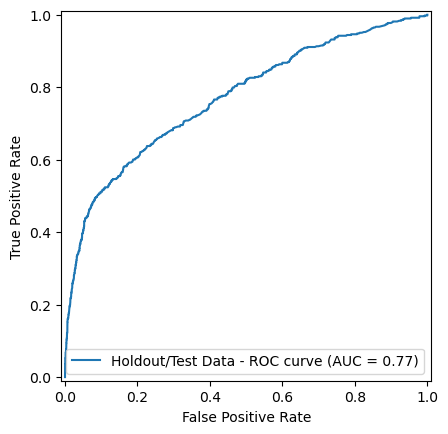

In [67]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Holdout/Test Data - ROC curve')
display.plot()
plt.show()

#### Confusion matrix

2024/07/16 08:43:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


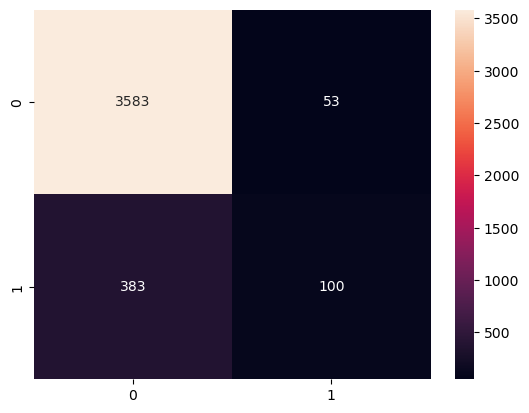

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, np.round(predictions))
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#### Precision-recall curve

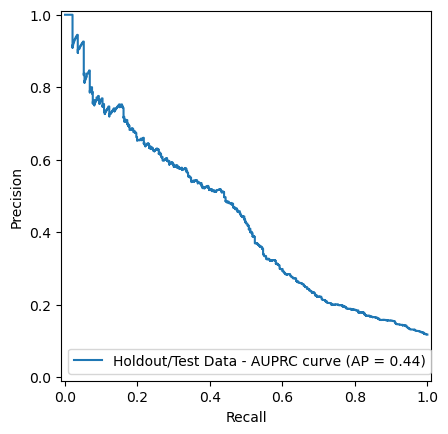

In [69]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(test_y, predictions)
average_precision= metrics.average_precision_score(test_y, predictions)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Holdout/Test Data - AUPRC curve')
pr_display.plot()
plt.show()

### Save charts to the MLflow run
You can use the [`mlflow.log_figure()`](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_figure) logging method to save [matplotlib](https://matplotlib.org/3.3.4/api/_as_gen/matplotlib.figure.Figure.html) or [plotly](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html) figures to a run.

In [70]:
def plot_confusion_matrix(
    cm, class_names, title="Confusion matrix", cmap=plt.cm.Blues, normalize=False
):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        ylim=(cm.shape[0] - 0.5, -0.5),
        xticklabels=class_names,
        yticklabels=class_names,
        title=title,
        ylabel="Ground truth label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax, fig

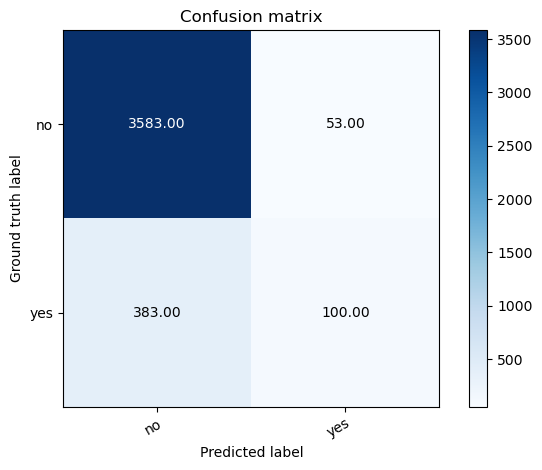

In [71]:
class_names = ["no", "yes"]
confusion_matrix = metrics.confusion_matrix(test_y, np.round(predictions))
ax, fig = plot_confusion_matrix(confusion_matrix, class_names)

In [72]:
print(f"Log confusion matrix to the model {mv.name} version {mv.version}")
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_id=mv.run_id):
    mlflow.log_figure(fig, "confusion_matrix.png")

Log confusion matrix to the model from-idea-to-prod-job-model-16-07-42-00 version 1


## Explore experiments and model registry with the MLflow UI
You can see all logged metrics, parameters, and artifacts in the MLflow UI. To launch the MLflow UI, choose **MLflow** in the **Application** pane of the Studio UI, select your MLflow server and choose **Open MLflow**:

![](img/mlflow-open.png)

In the MLflow UI you can browse experiments, runs, and registered models:

![](img/experiment-mlflow-2.png)

![](img/models-mlflow-2.png)

![](img/model-fig-mlflow.png)

---

## Optional: Hyperparameter optimization (HPO)
It takes about 20 minutes to run this section. The section is optional and you don't need to run it to continue with other notebooks. You can navigate directly to step 3 [notebook](03-sagemaker-pipeline.ipynb). If you would like to perform a model A/B test in **Additional topics** sections, you can execute this part to produce an alternative model.

[Amazon SageMaker automatic model tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), also called hyperparameter optimization (HPO), finds the best performing model against a defined objective metric by running many training jobs on the dataset using the algorithm and ranges of hyperparameters that you specify. SageMaker HPT supports random search, bayesian optimization, and [hyperband](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) as tuning strategies.

In [73]:
suffix = strftime('%d-%H-%M-%S', gmtime())
mlflow.set_experiment(f"from-idea-to-prod-hpo-{suffix}")
registered_hpo_model_name = f"from-idea-to-prod-hpo-model-{suffix}"

2024/07/16 08:45:04 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-hpo-16-08-45-04' does not exist. Creating a new experiment.


In [74]:
# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

In [75]:
# set up hyperparameter ranges
hp_ranges = {
    "min_child_weight": ContinuousParameter(1, 10),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
    "colsample_bytree": ContinuousParameter(0, 1),
    "gamma": ContinuousParameter(0, 10),
}

# set up the objective metric
objective = "validation:auc"

# Instantiate an XGBoost estimator object
hpo_estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    # use_spot_instances=True,  # Use spot instances to reduce cost
    # max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-hpo", # Prefix for training job name
    keep_alive_period_in_seconds=1800, # use the warm pool feature
)

hpo_estimator.set_hyperparameters(
    num_round=50, 
    objective="binary:logistic",
    eval_metric="auc", 
)

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=hpo_estimator,  # the SageMaker estimator object
    hyperparameter_ranges=hp_ranges,  # the range of hyperparameters
    max_jobs=10,  # total number of HPO jobs
    max_parallel_jobs=3,  # how many HPO jobs can run in parallel
    strategy="Bayesian",  # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",  # maximize or minimize the objective metric
    base_tuning_job_name="from-idea-to-prod-hpo",
    early_stopping_type="Auto",
)

Now run the HPO job. It takes about 10 minutes to complete.

In [76]:
tuner.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
)

INFO:sagemaker:Creating hyperparameter tuning job with name: from-idea-to-prod-hp-240716-0845


.........................................................!


In [77]:
tuner.describe()['HyperParameterTuningJobStatus']

'Completed'

### See HPO results
Now get the results and see the best training job.

In [78]:
best_training_job = tuner.describe()['BestTrainingJob']

In [79]:
best_training_job

{'TrainingJobName': 'from-idea-to-prod-hp-240716-0845-002-57025260',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:402709838713:training-job/from-idea-to-prod-hp-240716-0845-002-57025260',
 'CreationTime': datetime.datetime(2024, 7, 16, 8, 45, 41, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2024, 7, 16, 8, 46, 23, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2024, 7, 16, 8, 47, 58, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'alpha': '2.3177163266232976',
  'colsample_bytree': '0.9500824431680724',
  'eta': '0.2114590906081245',
  'gamma': '8.221861280846204',
  'max_depth': '3',
  'min_child_weight': '3.0212820082087015'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
  'Value': 0.7734000086784363},
 'ObjectiveStatus': 'Succeeded'}

### Register the best HPO model in the model registry
You can register the best HPO models with the hyperparameters, metrics, and model artifacts.

In [80]:
# Log parameters, metrics, and the model from the best job
with mlflow.start_run(run_name=f"best-hpo-job-{strftime('%d-%H-%M-%S', gmtime())}") as run:
    mlflow.log_metric(best_training_job['FinalHyperParameterTuningJobObjectiveMetric']['MetricName'].replace(':', '_'),
                      best_training_job['FinalHyperParameterTuningJobObjectiveMetric']['Value'])
    mlflow.log_params({'TrainingJobName':best_training_job['TrainingJobName'],
                       'TrainingJobArn':best_training_job['TrainingJobArn']})
    mlflow.log_params(best_training_job['TunedHyperParameters'])
    mlflow.xgboost.log_model(load_model(tuner.best_estimator().model_data), artifact_path="xgboost")

# Register the model
model_uri = f"runs:/{mlflow.last_active_run().info.run_id}/xgboost"
mv = mlflow.register_model(model_uri, registered_hpo_model_name)


2024-07-16 08:48:18 Starting - Preparing the instances for training
2024-07-16 08:48:18 Downloading - Downloading the training image
2024-07-16 08:48:18 Training - Training image download completed. Training in progress.
2024-07-16 08:48:18 Uploading - Uploading generated training model
2024-07-16 08:48:18 Completed - Resource reused by training job: from-idea-to-prod-hp-240716-0845-004-12c548d6


Successfully registered model 'from-idea-to-prod-hpo-model-16-08-45-04'.
2024/07/16 08:54:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: from-idea-to-prod-hpo-model-16-08-45-04, version 1
Created version '1' of model 'from-idea-to-prod-hpo-model-16-08-45-04'.


As the next step you need to deploy the best HPO model and test it. You can choose one of the following options below.

### Option 1: Deploy the HPO model from the tuner
Use `tuner.deploy()` method to deploy the best model as a SageMaker real-time endpoint.

In [81]:
hpo_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)


2024-07-16 08:48:18 Starting - Preparing the instances for training
2024-07-16 08:48:18 Downloading - Downloading the training image
2024-07-16 08:48:18 Training - Training image download completed. Training in progress.
2024-07-16 08:48:18 Uploading - Uploading generated training model
2024-07-16 08:48:18 Completed - Resource reused by training job: from-idea-to-prod-hp-240716-0845-004-12c548d6

INFO:sagemaker:Creating model with name: from-idea-to-prod-hp-2024-07-16-08-54-57-390


INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-hp-240716-0845-002-57025260
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-hp-240716-0845-002-57025260


------!

### Option 2: Deploy the HPO model from the MLflow model registry
<div class="alert alert-info">Don't run this code because 1P algorithms don't support MLflow yet and there is Python version mismatch in the model specification and 1P SageMaker container. Use the option 1 - deployment from the tuner - instead.</div>

Alternatively, if you have a registered model in the MLflow model registry, you can create a model in SageMaker, test it localy and then deploy to SageMaker. Refer to [Create a model in Amazon SageMaker with ModelBuilder](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-modelbuilder-creation.html) in the Developer Guide. For hands-on examples refer to this [GitHub repository](https://github.com/aws-samples/sagemaker-hosting/tree/main/SageMaker-Model-Builder).

The code below uses the SageMaker Python SDK class [ModelBuilder](https://sagemaker.readthedocs.io/en/stable/api/inference/model_builder.html) to build the model from the MLflow model registry.

In [18]:
from mlflow import MlflowClient
from sagemaker.serve import SchemaBuilder, ModelBuilder
from sagemaker.serve.mode.function_pointers import Mode

In [19]:
registered_hpo_model_name="from-idea-to-prod-hpo-model-16-08-45-04"
registered_model = MlflowClient().get_registered_model(name=registered_hpo_model_name)

In [20]:
# Model artifact S3 URL which is stored in MLflow registry
model_artifact_path = registered_model.latest_versions[0].source
model_artifact_path

's3://sagemaker-us-east-1-402709838713/mlflow/16-06-49-49/6/e25d95906dce4b7285f9315f23c4cab7/artifacts/xgboost'

In [38]:
model_builder = ModelBuilder(
    mode=Mode.SAGEMAKER_ENDPOINT,
    schema_builder=SchemaBuilder(test_x.values, test_y['y'].values),
    role_arn=sm_role,
    model_metadata={"MLFLOW_MODEL_PATH": model_artifact_path},
)

In [ ]:
hpo_model = model_builder.build()

In [ ]:
hpo_predictor = hpo_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

### Test the HPO-tuned model

In [82]:
hpo_predictions = np.array(hpo_predictor.predict(test_x.values), dtype=float).squeeze()
print(hpo_predictions)

[0.05705426 0.09261971 0.17325212 ... 0.04616636 0.04029178 0.03749999]


In [83]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(hpo_predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3602,34
1,392,91


There is only a small improvements for the model metrics. It can indicate, that the XGBoost model is already at it's limit. You might want to explore other model types to improve the prediction accuracy for this use case.

---

## Clean-up
To avoid charges, remove the hosted endpoint you created.

In [84]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-endpoint-16-08-27-27
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-endpoint-16-08-27-27


In [85]:
# run if you created a tuned predictor after HPO
try:
    hpo_predictor.delete_endpoint(delete_endpoint_config=True)
except NameError:
    print("You have no HPO predictor endpoint")

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-hp-240716-0845-002-57025260
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-hp-240716-0845-002-57025260


## Continue with the step 3
open the step 3 [notebook](03-sagemaker-pipeline.ipynb).

## Further development ideas for your real-world projects
- [Manage experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow.html)
- Use [Amazon SageMaker Data Wrangler](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler.html) for creating a no-code or low-code visual data processing and feature engineering flow.
- Try no-code [SageMaker Canvas](https://docs.aws.amazon.com/sagemaker/latest/dg/canvas.html) on your data to perform analysis and use automated ML to build models and generate predictions

## Additional resources
- [Using Docker containers with SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html)
- [How to create and use a custom SageMaker container: SageMaker hands-on workshop](https://sagemaker-workshop.com/custom/containers.html)
- [Amazon SageMaker Immersion Day](https://catalog.us-east-1.prod.workshops.aws/workshops/63069e26-921c-4ce1-9cc7-dd882ff62575/en-US)
- [Targeting Direct Marketing with Amazon SageMaker XGBoost](https://github.com/aws-samples/amazon-sagemaker-immersion-day/blob/master/processing_xgboost.ipynb)
- [Train a Machine Learning Model](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-train-a-model/)
- [Deploy a Machine Learning Model to a Real-Time Inference Endpoint](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-deploy-model-to-real-time-inference-endpoint/)
- [Amazon SageMaker 101 Workshop](https://catalog.us-east-1.prod.workshops.aws/workshops/0c6b8a23-b837-4e0f-b2e2-4a3ffd7d645b/en-US)
- [Amazon SageMaker 101 Workshop code repository](https://github.com/aws-samples/sagemaker-101-workshop)
- [Amazon SageMaker with XGBoost and Hyperparameter Tuning for Direct Marketing predictions](https://github.com/aws-samples/sagemaker-101-workshop/blob/main/builtin_algorithm_hpo_tabular/SageMaker%20XGBoost%20HPO.ipynb)

# Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>